In [ ]:
!pip install darts

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf
from darts.models import ARIMA
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [3]:
hotel_data = pd.read_csv('hotel_bookings.csv', encoding = 'latin1')

hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/07/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/07/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/07/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/07/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/07/15


In [5]:
# Creación de la columna 'date'
hotel_data['arrival_date_month'] = pd.to_datetime(hotel_data['arrival_date_month'], format='%B').dt.month
hotel_data['date'] = pd.to_datetime(hotel_data[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].rename(columns={'arrival_date_year': 'year', 'arrival_date_month': 'month', 'arrival_date_day_of_month': 'day'}))

# Filtrar para Resort Hotel y no canceladas
resort_not_canceled = hotel_data[(hotel_data['hotel'] == 'Resort Hotel') & (hotel_data['is_canceled'] == 0)]

# Crear la columna 'asistentes'
resort_not_canceled['asistentes'] = resort_not_canceled['adults'] + resort_not_canceled['children'].fillna(0)


# Transformar a serie de tiempo
time_series_data = resort_not_canceled.groupby('date')['asistentes'].sum().reset_index()


<ipython-input-5-16092c840e57>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resort_not_canceled['asistentes'] = resort_not_canceled['adults'] + resort_not_canceled['children'].fillna(0)


Text(0, 0.5, 'Número de Asistentes')

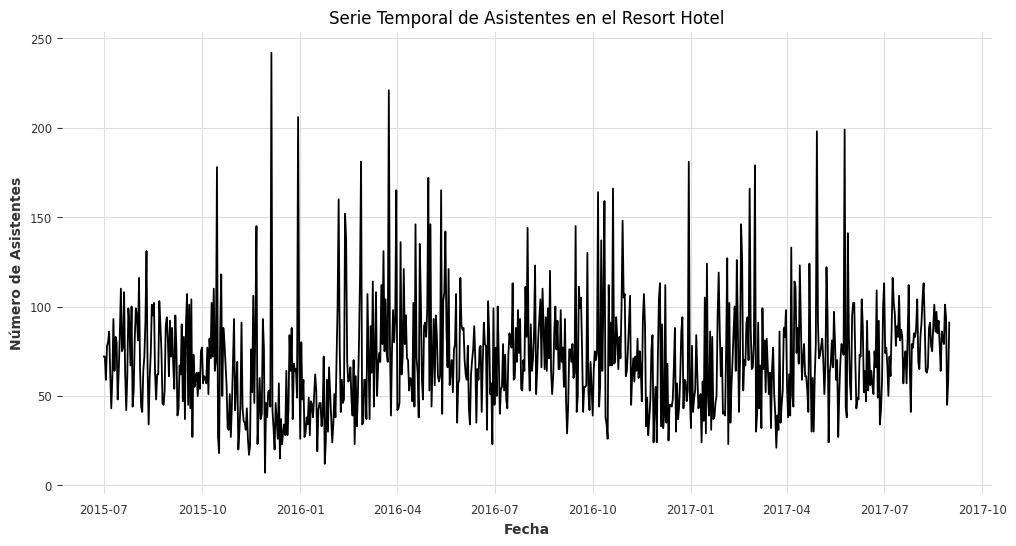

In [6]:
# Graficar la serie temporal de asistentes
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['date'], time_series_data['asistentes'])
plt.title('Serie Temporal de Asistentes en el Resort Hotel')
plt.xlabel('Fecha')
plt.ylabel('Número de Asistentes')

In [7]:
time_series_data['asistentes_log'] = np.log(time_series_data['asistentes'].replace(0, np.nan).dropna())

In [1]:
# Ajusta el modelo ARIMA utilizando auto_arima
auto_model = pm.auto_arima(time_series_data['asistentes_log'],
                           start_p=1,
                           seasonal=True,
                           m = 7,
                           stepwise=False,
                           suppress_warnings=True,
                           error_action="ignore",
                           max_order=None,
                           trace=True)

pm.auto_arima()
# Obtén el AIC del modelo ajustado
aic_value_auto = auto_model.aic()

NameError: name 'pm' is not defined

In [136]:


# Suponiendo que time_series_data es tu serie temporal
y = time_series_data['asistentes_log']
# Parámetros SARIMA
# Parámetros no estacionales (p, d, q)
p, d, q = 0, 1, 2 # Reemplaza con tus valores

# Parámetros estacionales (P, D, Q, m)
P, D, Q, m = 1, 0, 1, 7  # Reemplaza con tus valores (m es la periodicidad estacional)

# Ajuste del modelo SARIMA
modelo_sarima = sm.tsa.SARIMAX(y,
                               order=(p, d, q),
                              seasonal_order=(P, D, Q, m),
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                                trend='c')

# Ajuste del modelo
resultado_sarima = modelo_sarima.fit()

# Mostrar el resumen del modelo
print(resultado_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      asistentes_log   No. Observations:                  793
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -393.322
Date:                             Thu, 23 Nov 2023   AIC                            798.644
Time:                                     14:47:57   BIC                            826.615
Sample:                                          0   HQIC                           809.401
                                             - 793                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.332e-05      0.000      0.225      0.822      -0.000       0.000
ma.L1         -0.8272      

In [135]:


y = time_series_data['asistentes_log']
# Parámetros SARIMA
# Parámetros no estacionales (p, d, q)
p, d, q = 6, 1, 7 # Reemplaza con tus valores

# Parámetros estacionales (P, D, Q, m)
P, D, Q, m = 0, 0, 0, 0  # Reemplaza con tus valores (m es la periodicidad estacional)

# Ajuste del modelo SARIMA
modelo_sarima = sm.tsa.SARIMAX(y,
                               order=(p, d, q),
                              seasonal_order=(P, D, Q, m),
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                                trend='n')

# Ajuste del modelo
resultado_sarima = modelo_sarima.fit()

# Mostrar el resumen del modelo
print(resultado_sarima.summary())

                               SARIMAX Results                                
Dep. Variable:         asistentes_log   No. Observations:                  793
Model:               SARIMAX(6, 1, 7)   Log Likelihood                -381.896
Date:                Thu, 23 Nov 2023   AIC                            791.793
Time:                        14:47:20   BIC                            857.095
Sample:                             0   HQIC                           816.903
                                - 793                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0300      0.073    -14.171      0.000      -1.172      -0.888
ar.L2         -0.8923      0.095     -9.410      0.000      -1.078      -0.706
ar.L3         -0.9124      0.069    -13.273      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [55]:

asistentes_ts = TimeSeries.from_dataframe(time_series_data.dropna(subset=['asistentes_log']), 'date', 'asistentes_log', fill_missing_dates=True, freq='D')

# Diferenciando la serie logarítmica
asistentes_diff = asistentes_ts.diff()

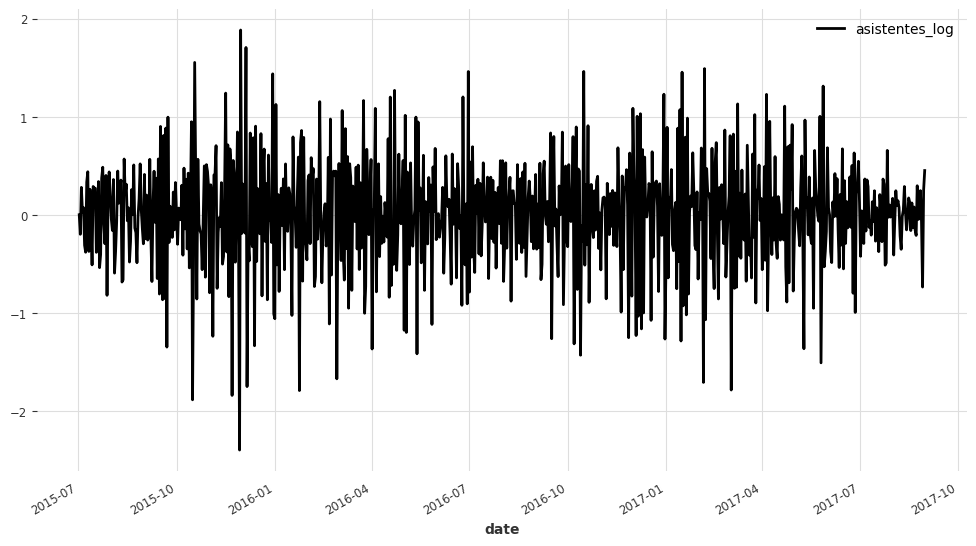

In [56]:
plt.figure(figsize=(12, 6))
asistentes_diff.plot()
plt.show()

In [57]:

asistentes_diff_pd = asistentes_diff.pd_series()

# Aplicar la prueba de Dickey-Fuller Aumentada
result = adfuller(asistentes_diff_pd.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.553695
p-value: 0.000000


# Tener en mente un d=1, ya está identificado

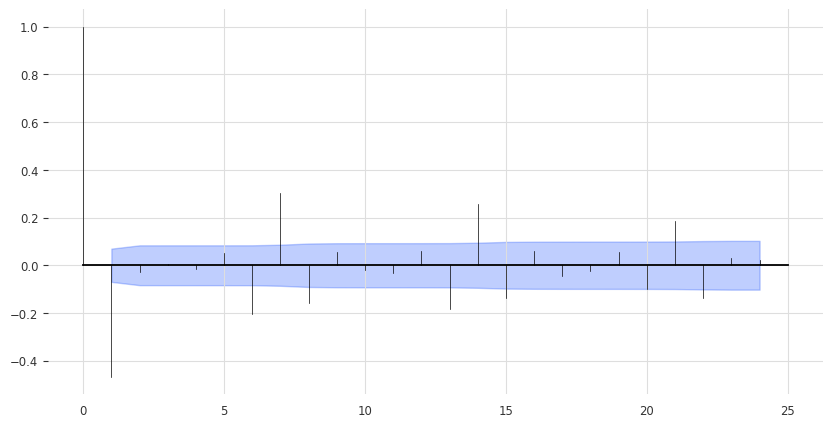

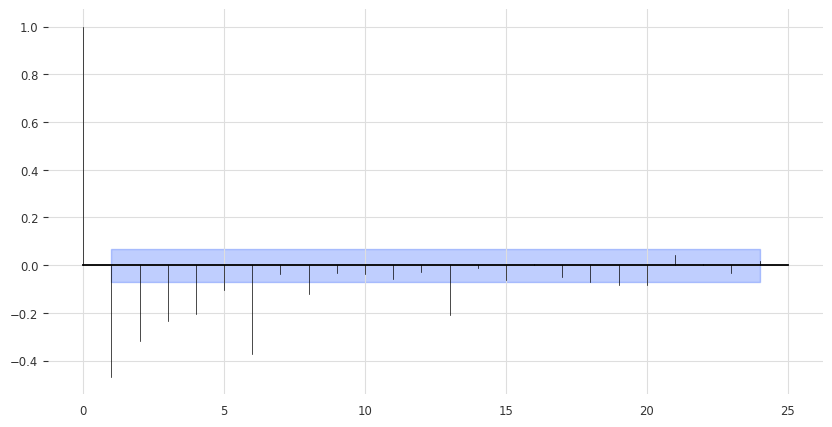

In [58]:
# Graficar ACF
plot_acf(asistentes_diff)

# Graficar PACF
plot_pacf(asistentes_diff)

# se propone un m=7, o s=7 dependiendo la notación

In [15]:
import statsmodels.api as sm

# Suponiendo que time_series_data es tu serie temporal
y = time_series_data['asistentes_log']
# Parámetros SARIMA
# Parámetros no estacionales (p, d, q)
p, d, q = 6, 1, 6 # Reemplaza con tus valores

# Parámetros estacionales (P, D, Q, m)
P, D, Q, m = 0, 0, 4, 7  # Reemplaza con tus valores (m es la periodicidad estacional)

# Ajuste del modelo SARIMA
modelo_sarima = sm.tsa.SARIMAX(y,
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, m),
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               trend = 'n')

# Ajuste del modelo
resultado_sarima = modelo_sarima.fit()

# Mostrar el resumen del modelo
print(resultado_sarima.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                          SARIMAX Results                                           
Dep. Variable:                               asistentes_log   No. Observations:                  793
Model:             SARIMAX(6, 1, 6)x(0, 0, [1, 2, 3, 4], 7)   Log Likelihood                -377.532
Date:                                      Thu, 23 Nov 2023   AIC                            789.065
Time:                                              20:58:47   BIC                            867.764
Sample:                                                   0   HQIC                           819.376
                                                      - 793                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9813      0.664  